In [1]:
import pandas as pd
import re 

# Gensim for topic modeling
import gensim
from gensim.utils import simple_preprocess
from gensim import matutils, models
import gensim.corpora as corpora
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy
import scipy.sparse

# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shawn.teo.2019\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [2]:
# !pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.0.0/en_core_web_sm-3.0.0.tar.gz
# !pip install pyLDAvis

In [3]:
ori_df = pd.read_csv('../Data/Raw Data/final_dataset_log.csv')

ori_df = ori_df.dropna()

print(ori_df.shape)
ori_df.head()

df = ori_df.sample(n=5000, random_state=999)
print(df.shape)

(90333, 24)
(5000, 24)


In [4]:
# Convert to list
data = df.review.values.tolist()


def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [5]:
# # Let's start with 2 topics.
# lda_model = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=2, passes=10)
# lda_model.print_topics()

In [6]:
# Convert to list
data = df.review.values.tolist()
data[:5]
# Remove @mentions 


["Nice soup. I couldn't get a serrano chili and had to use jalapeno instead. I could be for this reason that I found the soup a bit more bland than I would have liked. I added some freshly ground pepper and Cajun seasoning and loved it that way. Made for Newest Zaar Tag.",
 "This was good.  I like to used red, but couldn't find organic, so used white.  Used Recipe Secrets veg. soup mix.  The mayo mix easily makes enough for 3 lbs of potatoes.  I had over 2 1/2 lbs and it was still alot of sauce.  Made with recipe#184304.  Great combo.",
 "Awesome soup!! Instead of kielbasa I used chorizo because my stomach doesn't like kielbasa. For the smoked touch I added a tad smoked paprika. Actually it was the story behind the soup that attracted me, but the soup itself is so good that I will make it again and again. Thanks for sharing story and recipe :)",
 'I can see why this recipe has so many positive reviews. The arugula, shallot and gouda combo is incredible. Some crisp crumbled bacon on the

# remove stopwords 

In [7]:
# Remove urls (remove a word starting with http)
# data = [re.sub(r'@\w+', '', sent) for sent in data]
# data = [re.sub(r'http\S+', '', sent) for sent in data]

nltk.download('punkt')
nltk.download('stopwords')

# set stop words
stop_words = stopwords.words('english')

stop_words.extend([ 'bit', 'from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'lot', 'lack', 'make', 'di', 'havena', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come', 'from', 'subject', 're', 'edu', 'use', 'amp', 'een', 'ia', 'es', 'ich', 'das', 'ita', 'ich', 'das', 'der', 'aŒ'])


newdata = []
for sent in data:
    # tokenize
    tokenized_review = word_tokenize(sent)
    # standardize to lower case
    lower_review = [w.lower() for w in tokenized_review]
    # keep token words which are text
    text_words_only = [w for w in lower_review if re.search('^[a-z]+$',w)]
    text_stopremoved = [w for w in text_words_only if w not in stop_words]
    text_joined = " ".join(text_stopremoved)
    newdata.append(text_joined)

newdata[:5]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shawn.teo.2019\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shawn.teo.2019\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


['soup serrano chili jalapeno instead reason found soup bland liked added freshly ground pepper cajun seasoning loved way made newest zaar tag',
 'like used red find organic used white used recipe secrets veg soup mix mayo mix easily makes enough lbs potatoes lbs still alot sauce made recipe great combo',
 'awesome soup instead kielbasa used chorizo stomach like kielbasa smoked touch added tad smoked paprika actually story behind soup attracted soup thanks sharing story recipe',
 'recipe positive reviews arugula shallot gouda combo incredible crisp crumbled bacon top perfect breakfast lunch dinner',
 'pretty much followed ingredients except short red onion pepper yellow jalapeno expected heat reheating leftovers adding jamaiican pepper shrimp needs used smells wonderful']

In [8]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(newdata))

print(data_words[:1])

[['soup', 'serrano', 'chili', 'jalapeno', 'instead', 'reason', 'found', 'soup', 'bland', 'liked', 'added', 'freshly', 'ground', 'pepper', 'cajun', 'seasoning', 'loved', 'way', 'made', 'newest', 'zaar', 'tag']]


In [9]:
# Build the bigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=10) # higher threshold fewer phrases.

# Faster way to get a sentence clubbed as a bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

# Form Bigrams
data_words_bigrams = make_bigrams(data_words)


In [10]:
def lemmatization(texts, allowed_postags=['NOUN']):
    """"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component
# For normal use
# !python -m spacy download en_core_web_sm
# nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# For Colab use
import en_core_web_sm
nlp = en_core_web_sm.load()

print("Before Lemmatization:", data_words_bigrams[:1])

# Do lemmatization keeping only noun
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'PROPN',"ADJ"])

print("After Lemmatization: ", data_lemmatized[:1])


Before Lemmatization: [['soup', 'serrano', 'chili', 'jalapeno', 'instead', 'reason', 'found', 'soup', 'bland', 'liked', 'added', 'freshly_ground', 'pepper', 'cajun', 'seasoning', 'loved', 'way', 'made_newest', 'zaar_tag']]
After Lemmatization:  [['soup', 'serrano', 'chili', 'jalapeno', 'reason', 'soup', 'bland', 'freshly_ground', 'pepper', 'cajun', 'seasoning', 'way', 'zaar_tag']]


# remove stop words again because after lematizing there may be shortened junk words that dont make sense

In [11]:
# Remove urls (remove a word starting with http)
data = [re.sub(r'@\w+', '', sent) for sent in data]
data = [re.sub(r'http\S+', '', sent) for sent in data]

nltk.download('punkt')
nltk.download('stopwords')

# set stop words
stop_words = stopwords.words('english')
stop_words.extend(["thank","thanks","great","way","dh","wonderful"])
stop_words.extend(['thank', 'bit', 'recipe', 'from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'lot', 'lack', 'make', 'di', 'havena', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come', 'from', 'subject', 're', 'edu', 'use', 'amp', 'een', 'ia', 'es', 'ich', 'das', 'ita', 'ich', 'das', 'der', 'aŒ'])


newdata = []
for data_sent in data_lemmatized:

    text_stopremoved = [w for w in data_sent if w not in stop_words]
    newdata.append(text_stopremoved)
# newdata[:5]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shawn.teo.2019\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shawn.teo.2019\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [12]:
# Create Dictionary
id2word = corpora.Dictionary(newdata)
id2word.filter_extremes(no_below=1.5, no_above=0.8) # this will filter out words that are less frequen

# Create Corpus
texts = newdata

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 2), (10, 1)]]


In [13]:
print(id2word[0], id2word[1], id2word[2], id2word[3], id2word[4])


bland cajun chili freshly_ground jalapeno


# adjust the number of models here

In [14]:
min_topic = 2
max_topic= 20
for i in range(min_topic,max_topic):
    lda_model = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=i, passes=10)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=newdata, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('\nCoherence Score: ', coherence_lda)
    


Coherence Score:  0.2931023494737897

Coherence Score:  0.3069233440488573

Coherence Score:  0.3219961280610224

Coherence Score:  0.3329321864207986

Coherence Score:  0.3395801441344292

Coherence Score:  0.3364338033913502

Coherence Score:  0.35959311314044606

Coherence Score:  0.3341104150227522

Coherence Score:  0.3380988838810424

Coherence Score:  0.32793417587945217

Coherence Score:  0.3319747351926163

Coherence Score:  0.3332972497408395

Coherence Score:  0.35194218591399323

Coherence Score:  0.33810969918658185

Coherence Score:  0.34178211032534345

Coherence Score:  0.3558681272285516

Coherence Score:  0.3153164602607758

Coherence Score:  0.32019488981687694


In [35]:
lda_model = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=17, passes=10)
for num ,topic in lda_model.show_topics(formatted=True, num_topics=17, num_words=10):
    print(str(num)+": "+ topic)

0: 0.062*"bread" + 0.024*"flavor" + 0.024*"loaf" + 0.021*"little" + 0.018*"spice" + 0.016*"roll" + 0.014*"lovely" + 0.012*"perfect" + 0.012*"orange" + 0.011*"texture"
1: 0.054*"cookie" + 0.033*"cake" + 0.025*"flour" + 0.023*"chocolate" + 0.021*"muffin" + 0.021*"dough" + 0.017*"cup" + 0.015*"butter" + 0.015*"cinnamon" + 0.013*"moist"
2: 0.064*"sauce" + 0.023*"meat" + 0.020*"tender" + 0.019*"pork" + 0.017*"flavor" + 0.015*"chicken" + 0.015*"star" + 0.014*"fish" + 0.012*"excellent" + 0.012*"easy"
3: 0.027*"chicken" + 0.024*"minute" + 0.016*"flavor" + 0.016*"marinade" + 0.014*"time" + 0.012*"hour" + 0.012*"sauce" + 0.011*"taste" + 0.011*"ingredient" + 0.010*"onion"
4: 0.052*"sweet" + 0.022*"dessert" + 0.018*"sugar" + 0.017*"easy" + 0.017*"little" + 0.017*"milk" + 0.016*"taste" + 0.015*"delicious" + 0.014*"juice" + 0.014*"cream"
5: 0.025*"little" + 0.014*"sauce" + 0.012*"love" + 0.011*"lt_gt" + 0.010*"next_time" + 0.010*"leftover" + 0.010*"salt" + 0.010*"taste" + 0.010*"flavor" + 0.010*"dif

- topic 0: bread
- topic 1: sweet pastries
- topic 2: poultry
- topic 3: chicken
- topic 4: sweet liquid
- topic 5: -
- topic 6: pie
- topic 7: salad
- topic 8: salad
- topic 9: 
- topic 10: chicken
- topic 12: potato
- topic 13: rice
- topic 14: burger
- topic 15: soup
- topic 16: dessert

In [23]:
# Build LDA model 8 17

lda_model = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=17, passes=10)
lda_model.print_topics()

[(0,
  '0.020*"rita" + 0.019*"sugar" + 0.018*"peach" + 0.014*"fresh" + 0.014*"banana" + 0.014*"salad" + 0.012*"easy" + 0.012*"frozen" + 0.011*"swap" + 0.011*"fantastic"'),
 (1,
  '0.026*"little" + 0.025*"cake" + 0.021*"top" + 0.020*"pan" + 0.018*"cheese" + 0.017*"half" + 0.016*"potato" + 0.009*"sauce" + 0.009*"moist" + 0.009*"small"'),
 (2,
  '0.048*"marinade" + 0.030*"chicken" + 0.027*"flavor" + 0.026*"easy" + 0.020*"bar" + 0.020*"love" + 0.019*"chicken_breast" + 0.015*"forum" + 0.014*"oil" + 0.014*"chip"'),
 (3,
  '0.038*"onion" + 0.021*"dish" + 0.020*"bacon" + 0.019*"potato" + 0.014*"spinach" + 0.011*"garlic" + 0.011*"delicious" + 0.011*"flavor" + 0.010*"cheese" + 0.010*"basil"'),
 (4,
  '0.027*"easy" + 0.022*"time" + 0.020*"excellent" + 0.018*"delicious" + 0.018*"butter" + 0.016*"half" + 0.014*"pan" + 0.013*"sauce" + 0.013*"dinner" + 0.012*"minute"'),
 (5,
  '0.026*"sweet" + 0.023*"apple" + 0.021*"cinnamon" + 0.019*"cup" + 0.018*"texture" + 0.016*"pie" + 0.015*"time" + 0.014*"desse

# coherence score of 0.5 is the best the lower the perplexity score the better

In [24]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=newdata, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.9435799914351195

Coherence Score:  0.325599372946686


In [25]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
12    -0.149626 -0.050856       1        1  10.934362
3     -0.091017 -0.038080       2        1   7.271843
7      0.199273 -0.064299       3        1   7.078814
4     -0.062173  0.027793       4        1   6.574433
1     -0.016821  0.115223       5        1   6.081643
14    -0.024305 -0.073289       6        1   6.069076
9     -0.099379 -0.095836       7        1   5.907111
16    -0.071260 -0.010051       8        1   5.845274
13    -0.114827  0.099667       9        1   5.839641
8     -0.072350  0.031060      10        1   5.715679
5      0.208244  0.096118      11        1   5.610873
6      0.013604 -0.027321      12        1   5.158723
11     0.182892  0.074052      13        1   4.956158
10    -0.051690 -0.085917      14        1   4.706413
0      0.167448 -0.143805      15        1   4.636356
15    -0.023803  0.247288      16        1   4.516857
2      0.005790 -0.101749      17        1   3.096744, topic_info=               Term        Freq       Total Category  logprob  loglift
373           bread  287.000000  287.000000  Default  30.0000  30.0000
125          cookie  294.000000  294.000000  Default  29.0000  29.0000
9              soup  373.000000  373.000000  Default  28.0000  28.0000
60          chicken  403.000000  403.000000  Default  27.0000  27.0000
223          flavor  788.000000  788.000000  Default  26.0000  26.0000
..              ...         ...         ...      ...      ...      ...
88            salad   24.417926  282.726481  Topic17  -4.4689   1.0257
448         amazing   17.031341   67.782575  Topic17  -4.8292   2.0936
495             day   19.490306  211.624469  Topic17  -4.6943   1.0899
31   thanks_sharing   18.013065  204.515544  Topic17  -4.7731   1.0453
216       delicious   19.608198  710.569889  Topic17  -4.6883  -0.1153

[1174 rows x 6 columns], token_table=      Topic      Freq                  Term
term                                       
2161     17  0.917773              absolute
178       5  0.068563  absolutely_delicious
178      10  0.754193  absolutely_delicious
178      14  0.137126  absolutely_delicious
2387      3  0.843487                acadia
...     ...       ...                   ...
10        1  0.189370              zaar_tag
10        8  0.757482              zaar_tag
3012      3  0.845049                 zingo
2708     10  0.950746                   zip
1951      4  0.977051                   zwt

[2719 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[13, 4, 8, 5, 2, 15, 10, 17, 14, 9, 6, 7, 12, 11, 1, 16, 3])

In [26]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['dominant_topic', 'topic_perc_contrib', 'keywords']
    
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus)
df_topic_sents_keywords.head()


,dominant_topic,topic_perc_contrib,keywords
0,12.0,0.4451,"soup, dish, pepper, chicken, rice, flavor, mea..."
1,3.0,0.5236,"onion, dish, bacon, potato, spinach, garlic, d..."
2,8.0,0.5789,"steak, dinner, flavor, night, perfect, husband..."
3,3.0,0.7346,"onion, dish, bacon, potato, spinach, garlic, d..."
4,9.0,0.6930,"chicken, pepper, tasty, chili, flavour, taste,..."


# wordcloud

IndexError: list index out of range

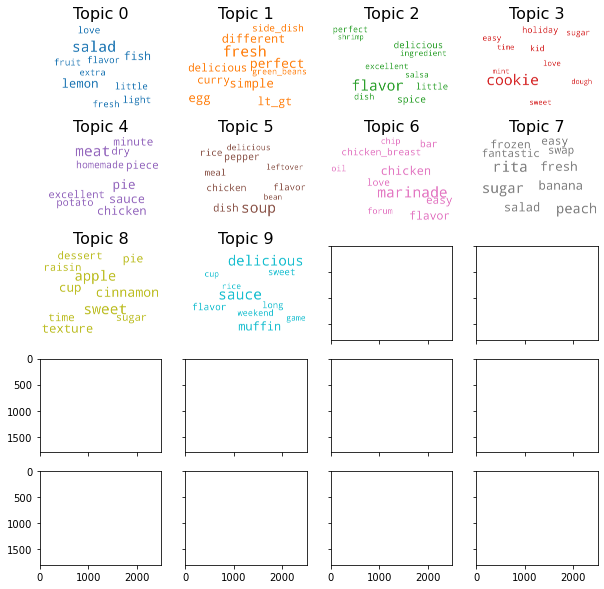

In [31]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

# adjust number of plots here
fig, axes = plt.subplots(5,4, figsize=(10,10), sharex=True, sharey=True)


for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)

    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [28]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_lda = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('dominant_topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_lda = pd.concat([sent_topics_sorteddf_lda, 
                                             grp.sort_values(['topic_perc_contrib'], ascending=[0]).head(3)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_lda.reset_index(drop=True, inplace=True)

# # Show
sent_topics_sorteddf_lda

,dominant_topic,topic_perc_contrib,keywords
0,0.0,0.9446,"rita, sugar, peach, fresh, banana, salad, easy..."
1,0.0,0.9328,"rita, sugar, peach, fresh, banana, salad, easy..."
2,0.0,0.9327,"rita, sugar, peach, fresh, banana, salad, easy..."
3,1.0,0.9372,"little, cake, top, pan, cheese, half, potato, ..."
4,1.0,0.9216,"little, cake, top, pan, cheese, half, potato, ..."
5,1.0,0.9144,"little, cake, top, pan, cheese, half, potato, ..."
6,2.0,0.9477,"marinade, chicken, flavor, easy, bar, love, ch..."
7,2.0,0.9328,"marinade, chicken, flavor, easy, bar, love, ch..."
8,2.0,0.8431,"marinade, chicken, flavor, easy, bar, love, ch..."
9,3.0,0.9675,"onion, dish, bacon, potato, spinach, garlic, d..."


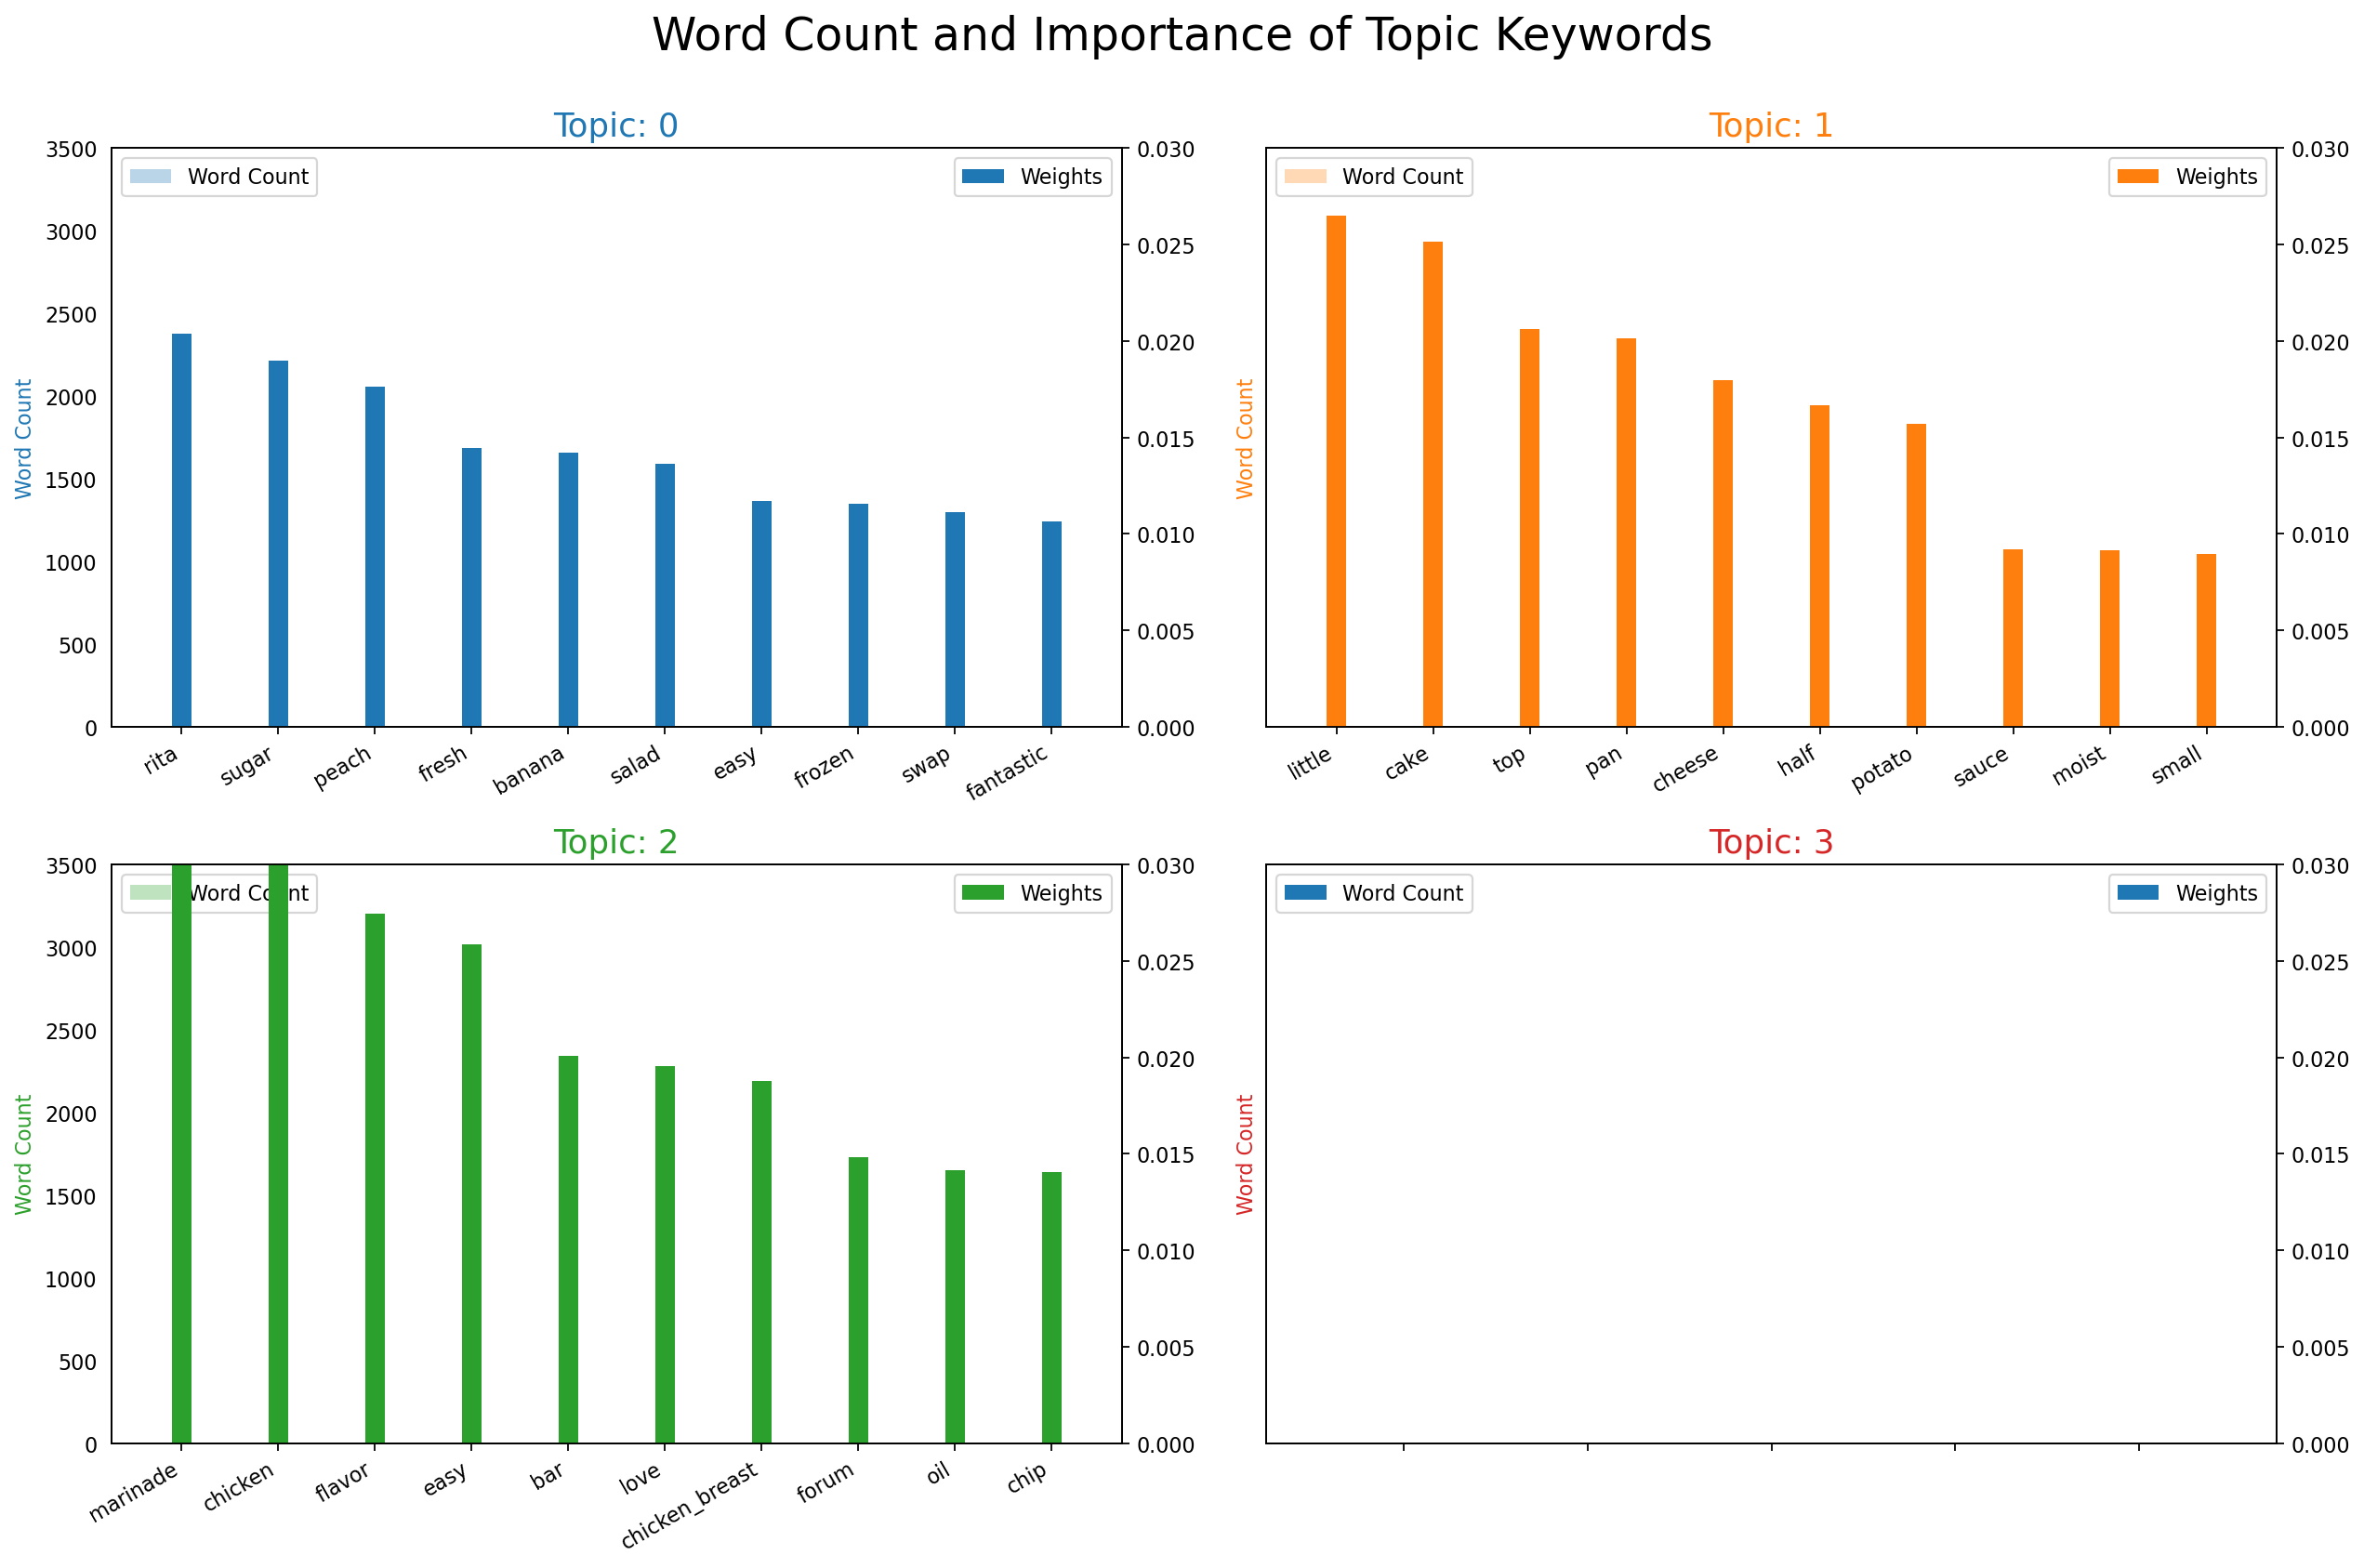

In [29]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in df for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [30]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import numpy as np

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
     
    topic_weights.append([w for w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3860 samples in 0.006s...
[t-SNE] Computed neighbors for 3860 samples in 0.143s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3860
[t-SNE] Computed conditional probabilities for sample 2000 / 3860
[t-SNE] Computed conditional probabilities for sample 3000 / 3860
[t-SNE] Computed conditional probabilities for sample 3860 / 3860
[t-SNE] Mean sigma: 0.009574
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.800968
[t-SNE] KL divergence after 1000 iterations: 0.234160


Loading BokehJS ...